In [91]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np





This Jupyter code aims to analyze the data regarding the executed jobs by all the straddle carriers (SC) and convert it to insight by:  
  
1) Defining file paths  
2) Defining a regex pattern to extract jobs execution information for all straddle carriers  
3) Reading job features and timestamps into a DataFrame  
4) Visualizing total waiting times per SC  
5) Categorizing locations into different groups  
6) Separating job sequences of selected SCs for comparison  
7) Analyzing waiting times in locations due to limited access  
8) Calculating the duration of visits to different locations  
9) Analyzing the number of SCs present at specific locations over time  


In [92]:
# ---------------------------------------------
# Define file paths
# ---------------------------------------------


log_file_path = "logger_all.log"  # Input log file
matched_lines_path = "matched_lines_all_SCs_jobs.txt"  # Output file with matched lines
processed_log = "processed_log/processed_log_all_SCs_jobs.csv"  # Output file of processed log




In [93]:
# ---------------------------------------------
# Define a regex pattern to extract jobs execution information for all straddle carriers
# ---------------------------------------------


log_pattern = re.compile(
    r"(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}) INFO (SC\d+) "
    r"\(TO: (TO_CO_TFTU\d+), CO: CO_TFTU\d+, (\w+)\) "
    r"([\w\s]+) ((?:to|at) [\w.]+)"  
    r"(?:; (\d+) s)?"  
)
try:
    # Open files for reading and writing
    with open(log_file_path, "r") as file, open(matched_lines_path, "w") as match_file:
        for line in file:
            match = log_pattern.search(line)
            if match:
                # Write the matched line to a file
                match_file.write(line)

except FileNotFoundError:
    print(f"Error: Log file '{log_file_path}' not found.")
except Exception as e:
    print(f"An error occurred while processing the log file: {e}")

               

In [94]:
# ---------------------------------------------
# Read the features and timestamps of jobs in the form of a Dataframe
# ---------------------------------------------


with open(matched_lines_path, "r") as file:
    log_data = file.readlines()

# Parse the log and store in a list
data = []
for line in log_data:
    match = log_pattern.match(line.strip())  # Remove leading/trailing spaces
    if match:
        timestamp, sc, to, action, activity, location, duration = match.groups()
        # If duration is found, convert it to integer; else, set as 0 
        duration = int(duration) if duration else 0
        data.append([timestamp, sc, to, action, activity, location, duration])

# Create a DataFrame
df = pd.DataFrame(data, columns=["Timestamp", "SC", "TO", "Action", "Activity", "Location", "Duration"])

# Convert Timestamp to datetime
df["Timestamp"] = pd.to_datetime(df["Timestamp"])

# Add new rows with "arriving" activity in updated information
new_rows = []
for idx, row in df[(df["Activity"] == "driving")].iterrows():
    # Calculate the new timestamp by adding the duration to the existing timestamp
    new_timestamp = row["Timestamp"] + pd.Timedelta(seconds=row["Duration"])

    # Create a new row with updated details
    new_row = row.copy()
    new_row["Timestamp"] = new_timestamp
    new_row["Activity"] = "arriving"
    new_row["Location"] = f"at {row['Location'][3:]}"  
    new_rows.append(new_row)

# Append the new rows to the original DataFrame
df = pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True)

# Custom sort order for Activity
activity_order = ["finished", "driving", "arriving","waited", "working"]

# Convert Activity to a categorical type with the custom order
df["Activity"] = pd.Categorical(df["Activity"], categories=activity_order, ordered=True)

# Sort the DataFrame by Timestamp and Activity
df = df.sort_values(by=["Timestamp", "Activity"]).reset_index(drop=True)


# Save the processed data to a CSV file 
df.to_csv(processed_log, index=False)

# Display the DataFrame
print(df)


               Timestamp     SC                TO Action  Activity  \
0    2024-11-14 10:27:10  SC001  TO_CO_TFTU000018   PICK   driving   
1    2024-11-14 10:27:10  SC002  TO_CO_TFTU000023   PICK   driving   
2    2024-11-14 10:27:10  SC003  TO_CO_TFTU000020   PICK   driving   
3    2024-11-14 10:27:10  SC004  TO_CO_TFTU000001   PICK   driving   
4    2024-11-14 10:27:10  SC005  TO_CO_TFTU000019   PICK   driving   
...                  ...    ...               ...    ...       ...   
2368 2024-11-14 11:39:02  SC007  TO_CO_TFTU000269   DROP  finished   
2369 2024-11-14 11:39:16  SC019  TO_CO_TFTU000281   DROP  arriving   
2370 2024-11-14 11:39:16  SC019  TO_CO_TFTU000281   DROP   working   
2371 2024-11-14 11:39:40  SC016  TO_CO_TFTU000285   DROP  finished   
2372 2024-11-14 11:40:16  SC019  TO_CO_TFTU000281   DROP  finished   

         Location  Duration  
0        to QC003        31  
1        to QC003        29  
2        to QC003        27  
3        to QC001         8  
4        

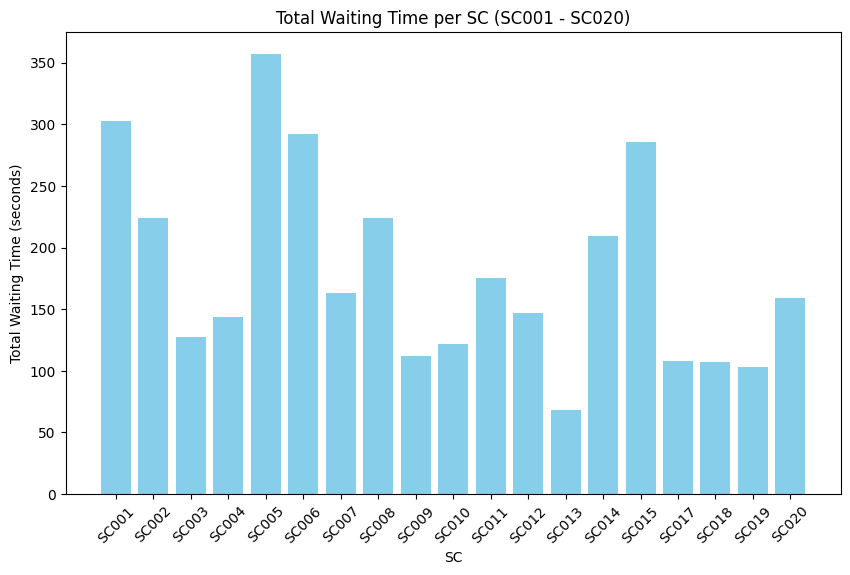

Total Waiting Time: 3430


In [95]:
# ---------------------------------------------
# Create a copy of the original dataframe to focus on waiting times
# ---------------------------------------------


df_waited = df.copy()
unique_scs = df_waited["SC"].unique()

# Filter rows where Activity is "waited" 
df_waited = df_waited[(df_waited["Activity"] == "waited") & (df_waited["SC"].isin(unique_scs))]

# Aggregate total waiting duration for each SC
df_waited = df_waited.groupby("SC")["Duration"].sum().reset_index()

# Plot the aggregated waiting times in a bar chart
plt.figure(figsize=(10, 6))
plt.bar(df_waited["SC"], df_waited["Duration"], color="skyblue")
plt.xlabel("SC")
plt.ylabel("Total Waiting Time (seconds)")
plt.title("Total Waiting Time per SC (SC001 - SC020)")
plt.xticks(rotation=45)
plt.show()

print(f"Total Waiting Time: {df_waited['Duration'].sum()}")

In [96]:
# ---------------------------------------------
# Categorize locations into different groups
# ---------------------------------------------


# Create the YARD list
YARD = [f"YARD001.{str(i).zfill(2)}" for i in range(1, 70)] + \
       [f"YARD002.{str(i).zfill(2)}" for i in range(1, 14)] + \
       [f"YARD003.{str(i).zfill(2)}" for i in range(1, 5)]

# Create the RAIL list
RAIL = [f"RAIL001.{str(i).zfill(2)}" for i in range(1, 110)]

# Create the WS list
WS = [f"WS{str(i).zfill(3)}.01" for i in range(1, 18)]

# Create the QC list
QC = ["QC001","QC003","QC004","QC005","QC006","QC007"]


# Function to categorize locations based on predefined groups
def categorize_location(location):
    import re
    
     # Extract the actual location name if prefixed with "at "
    match = re.search(r"at (.+)", location)
    if match:
        location = match.group(1).strip()  # Get the location name after "at "
    
    if location in YARD:
        return "Drop"
    elif location in RAIL:
        return "RAIL"
    elif location in WS:
        return "Drop"
    elif location in QC:
        return location  # Keep QC as it is
    else:
        return "Start"  # Catch-all for unknown locations

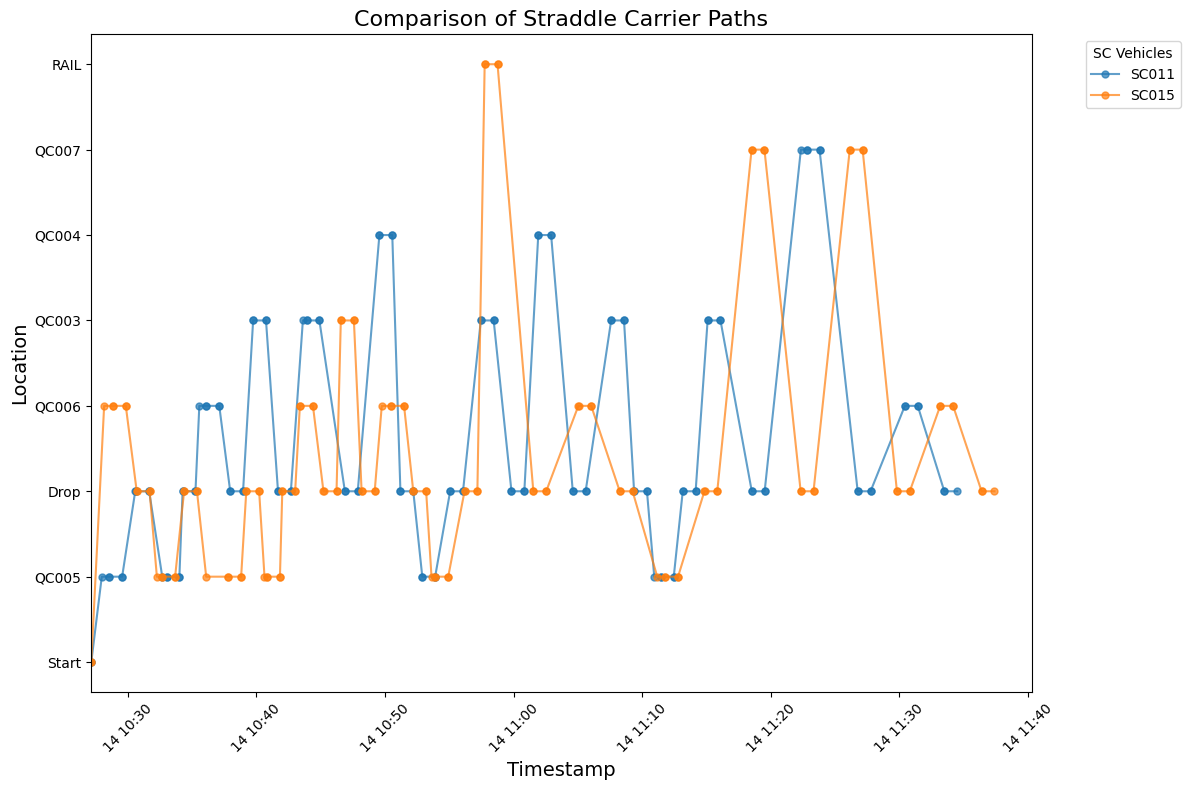

In [97]:
# ---------------------------------------------
# Separate the job sequences of selected SCs for comparison
# ---------------------------------------------


# Define the specific SCs to analyze
unique_scs = ['SC011', 'SC015']
#unique_scs = df["SC"].unique()  # Uncomment to analyze all SCs dynamically

plt.figure(figsize=(12, 8))  

# Define the complete categorical order for locations
location_categories = ["start"] + QC + ["WS", "YARD", "RAIL", "Other"]

for sc in unique_scs:
    df_SC = df[df["SC"] == sc].copy()  # Filter the dataset for the specific SC
    df_SC.reset_index(drop=True, inplace=True)  # Reset index after filtering
    df_SC.insert(0, "Row", range(1, len(df_SC) + 1))  # Add a sequential row number

    # Add an initial row representing the starting location
    row_zero = df_SC.iloc[0].copy()
    row_zero["Row"] = 0
    row_zero["Location"] = "start"
    df_SC = pd.concat([pd.DataFrame([row_zero]), df_SC], ignore_index=True)

    # Adjust "driving" activity locations to reflect the previous location  
    # since the timestamp of "driving" represents the start of movement
    for i in range(1, len(df_SC)):  
        if df_SC.loc[i, "Activity"] == "driving":
            df_SC.loc[i, "Location"] = df_SC.loc[i - 1, "Location"]

    # Save the processed data as a CSV file
    filename = f"processed_log/{sc}_executed_jobs.csv"
    df_SC.to_csv(filename, index=False)

    # Categorize locations using the predefined function
    df_SC["Location"] = df_SC["Location"].apply(categorize_location)

    # Sort by timestamp to ensure smooth transitions in visualization
    df_SC = df_SC.sort_values(by="Timestamp")

    # Plot the SC's movement over time
    plt.plot(
        df_SC["Timestamp"],
        df_SC["Location"],
        marker="o",
        linestyle="-",
        markersize=5,
        alpha=0.7,
        label=sc
    )

# Set x-axis limits based on the dataset's timestamp range
plt.xlim(df["Timestamp"].min(), df["Timestamp"].max())

# Customize plot labels and title
plt.title("Comparison of Straddle Carrier Paths", fontsize=16)
plt.xlabel("Timestamp", fontsize=14)
plt.ylabel("Location", fontsize=14)
plt.xticks(rotation=45)
plt.legend(title="SC Vehicles", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()  # Adjust layout to prevent overlap

plt.show()


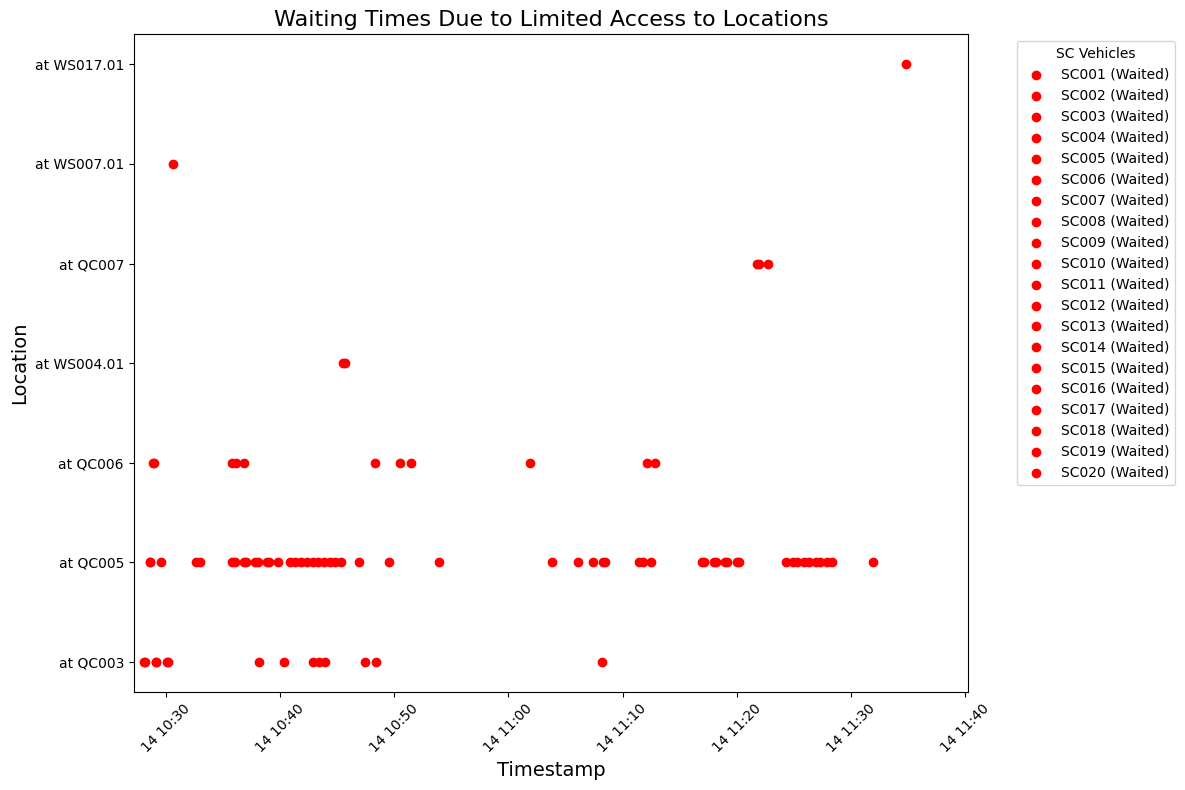

In [98]:
# ---------------------------------------------
# Analyze waiting time in locations due to limited access
# ---------------------------------------------


# Get unique straddle carrier (SC) values
unique_scs = df["SC"].unique()

plt.figure(figsize=(12, 8))  # Create a single figure for all plots

# Iterate through each SC to analyze waiting times
for sc in unique_scs:
    df_SC = df[df["SC"] == sc].copy()  # Create a filtered DataFrame for the current SC
    
    # Reset index and add a sequential 'Row' column from 1 to n
    df_SC.reset_index(drop=True, inplace=True)
    df_SC.insert(0, "Row", range(1, len(df_SC) + 1))

    # Add an initial row representing the starting location
    row_zero = df_SC.iloc[0].copy()
    row_zero["Row"] = 0
    row_zero["Location"] = "start"  # Set the initial location as "start"
    df_SC = pd.concat([pd.DataFrame([row_zero]), df_SC], ignore_index=True)

    # Adjust "driving" activity locations to reflect the previous location  
    # since the timestamp of "driving" represents the start of movement
    for i in range(1, len(df_SC)):  
        if df_SC.loc[i, "Activity"] == "driving":
            df_SC.loc[i, "Location"] = df_SC.loc[i - 1, "Location"]

    # Extract waiting time data (rows where activity is "waited")
    df_SC_waited = df_SC[df_SC["Activity"] == "waited"].copy()

    # Plot scatter points for "waited" activities in red
    plt.scatter(
        df_SC_waited["Timestamp"],
        df_SC_waited["Location"],
        color='red',
        marker='o',
        label=f"{sc} (Waited)"
    )

# Set x-axis limits based on the dataset's timestamp range
plt.xlim(df["Timestamp"].min(), df["Timestamp"].max())

# Customize plot labels and title
plt.title("Waiting Times Due to Limited Access to Locations", fontsize=16)
plt.xlabel("Timestamp", fontsize=14)
plt.ylabel("Location", fontsize=14)
plt.xticks(rotation=45)
plt.legend(title="SC Vehicles", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()  # Adjust layout to prevent overlap

plt.show()


In [99]:
# ---------------------------------------------
# Calculate the duration of visits to locations
# ---------------------------------------------


# Filter 'arriving' and 'finished' activities to track visit durations
arriving_df = df[df["Activity"] == "arriving"][["SC", "TO", "Action", "Location", "Timestamp"]].rename(columns={"Timestamp": "timestamp_start"})
finished_df = df[df["Activity"] == "finished"][["SC", "TO", "Action", "Location", "Timestamp"]].rename(columns={"Timestamp": "timestamp_end"})

# Merge both DataFrames based on SC, TO, Action, and Location to match arrival and departure times
df_duration = pd.merge(arriving_df, finished_df, on=["SC", "TO", "Action", "Location"], how="inner")

# Compute the visit duration by subtracting the arrival timestamp from the departure timestamp
df_duration["duration_visit"] = df_duration["timestamp_end"] - df_duration["timestamp_start"]

# Save the processed data to a CSV file
df_duration.to_csv("processed_log/all_visiting_duration.csv", index=False)

# Display the result
print(df_duration)

        SC                TO Action     Location     timestamp_start  \
0    SC004  TO_CO_TFTU000001   PICK     at QC001 2024-11-14 10:27:18   
1    SC014  TO_CO_TFTU000005   PICK     at QC003 2024-11-14 10:27:18   
2    SC013  TO_CO_TFTU000007   PICK     at QC003 2024-11-14 10:27:19   
3    SC012  TO_CO_TFTU000006   PICK     at QC003 2024-11-14 10:27:21   
4    SC010  TO_CO_TFTU000008   PICK     at QC003 2024-11-14 10:27:25   
..     ...               ...    ...          ...                 ...   
567  SC015  TO_CO_TFTU000274   DROP  at WS013.01 2024-11-14 11:36:23   
568  SC019  TO_CO_TFTU000281   PICK     at QC006 2024-11-14 11:36:48   
569  SC007  TO_CO_TFTU000269   DROP  at WS013.01 2024-11-14 11:38:02   
570  SC016  TO_CO_TFTU000285   DROP  at WS012.01 2024-11-14 11:38:40   
571  SC019  TO_CO_TFTU000281   DROP  at WS008.01 2024-11-14 11:39:16   

          timestamp_end  duration_visit  
0   2024-11-14 10:28:07 0 days 00:00:49  
1   2024-11-14 10:28:07 0 days 00:00:49  
2   2024-

C:\Users\miravani\AppData\Local\Temp\ipykernel_31284\2413549409.py:21: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  time_range = pd.date_range(df_location["timestamp_start"].min(), df_location["timestamp_end"].max(), freq="S")
C:\Users\miravani\AppData\Local\Temp\ipykernel_31284\2413549409.py:28: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  for t in pd.date_range(row["timestamp_start"], row["timestamp_end"], freq="S"):
C:\Users\miravani\AppData\Local\Temp\ipykernel_31284\2413549409.py:21: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  time_range = pd.date_range(df_location["timestamp_start"].min(), df_location["timestamp_end"].max(), freq="S")
C:\Users\miravani\AppData\Local\Temp\ipykernel_31284\2413549409.py:28: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  for t in pd.da

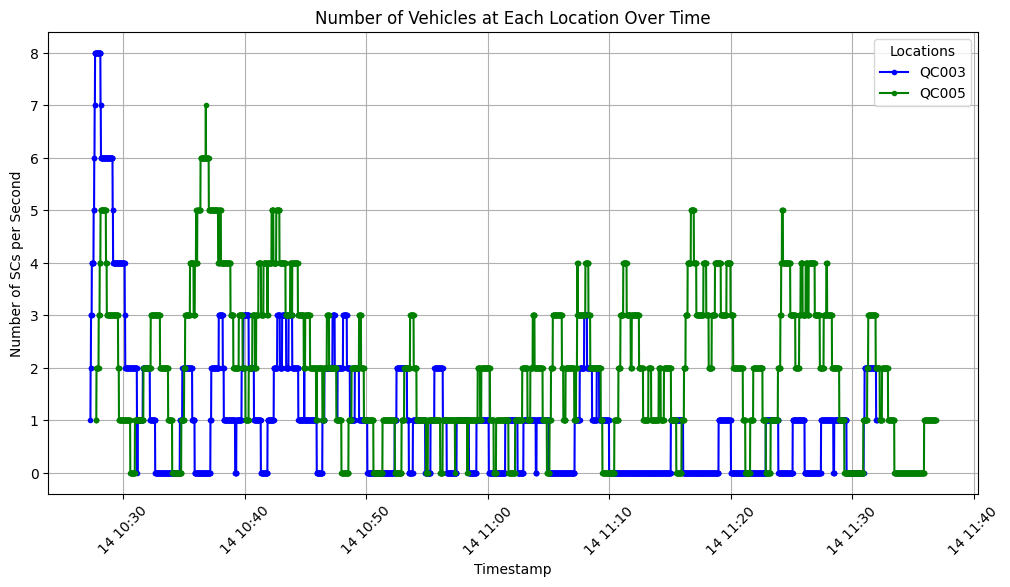

In [100]:
# ---------------------------------------------
# Analyze the duration of visits to specific locations
# ---------------------------------------------


# List of locations to analyze
locations = ["QC003", "QC005"]
colors = ["b", "g", "r", "c", "m", "y"]  # Assign different colors for each location

plt.figure(figsize=(12, 6))  

for location, color in zip(locations, colors):
    # Filter the dataset for the current location
    df_location = df_duration[df_duration["Location"] == f"at {location}"]

    if df_location.empty:
        print(f"No data for {location}, skipping...")
        continue  # Skip plotting if no data is available for this location

    # Generate a time range covering the earliest to latest recorded timestamps
    time_range = pd.date_range(df_location["timestamp_start"].min(), df_location["timestamp_end"].max(), freq="S")

    # Initialize a dictionary to count the number of SCs at each second
    time_counts = {time: 0 for time in time_range}

    # Count the number of SCs present at each timestamp
    for _, row in df_location.iterrows():
        for t in pd.date_range(row["timestamp_start"], row["timestamp_end"], freq="S"):
            time_counts[t] += 1

    # Convert the time count dictionary into a DataFrame for plotting
    df_plot = pd.DataFrame(time_counts.items(), columns=["Timestamp", "SC Count"])
    df_plot.sort_values("Timestamp", inplace=True)  # Ensure timestamps are sorted chronologically

    # Plot the number of SCs present at the location over time
    plt.plot(df_plot["Timestamp"], df_plot["SC Count"], marker=".", linestyle="-", color=color, label=location)

# Customize the plot
plt.xlabel("Timestamp")
plt.ylabel("Number of SCs per Second")
plt.title("Number of Vehicles at Each Location Over Time")
plt.xticks(rotation=45)
plt.grid()
plt.legend(title="Locations")  
plt.show()


C:\Users\miravani\AppData\Local\Temp\ipykernel_31284\2705957157.py:21: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  time_range = pd.date_range(df_location["timestamp_start"].min(), df_location["timestamp_end"].max(), freq="S")
C:\Users\miravani\AppData\Local\Temp\ipykernel_31284\2705957157.py:28: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  for t in pd.date_range(row["timestamp_start"], row["timestamp_end"], freq="S"):
C:\Users\miravani\AppData\Local\Temp\ipykernel_31284\2705957157.py:21: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  time_range = pd.date_range(df_location["timestamp_start"].min(), df_location["timestamp_end"].max(), freq="S")
C:\Users\miravani\AppData\Local\Temp\ipykernel_31284\2705957157.py:28: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  for t in pd.da

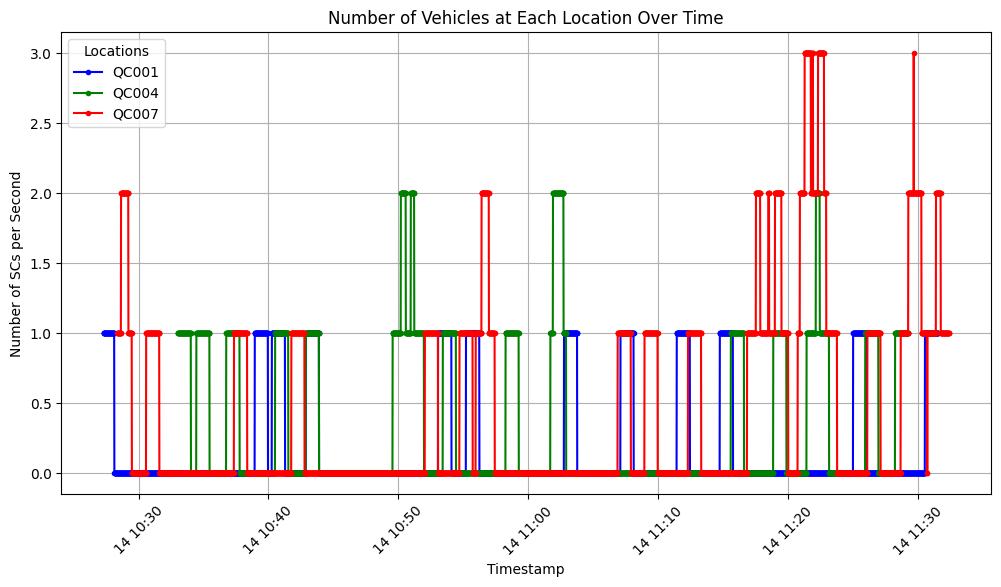

In [101]:
# ---------------------------------------------
# Analyze the duration of visits to specific locations
# ---------------------------------------------


# List of locations to analyze
locations = [ "QC001", "QC004", "QC007"]
colors = ["b", "g", "r", "c", "m", "y"]  # Assign different colors for each location

plt.figure(figsize=(12, 6))  

for location, color in zip(locations, colors):
    # Filter the dataset for the current location
    df_location = df_duration[df_duration["Location"] == f"at {location}"]

    if df_location.empty:
        print(f"No data for {location}, skipping...")
        continue  # Skip plotting if no data is available for this location

    # Generate a time range covering the earliest to latest recorded timestamps
    time_range = pd.date_range(df_location["timestamp_start"].min(), df_location["timestamp_end"].max(), freq="S")

    # Initialize a dictionary to count the number of SCs at each second
    time_counts = {time: 0 for time in time_range}

    # Count the number of SCs present at each timestamp
    for _, row in df_location.iterrows():
        for t in pd.date_range(row["timestamp_start"], row["timestamp_end"], freq="S"):
            time_counts[t] += 1

    # Convert the time count dictionary into a DataFrame for plotting
    df_plot = pd.DataFrame(time_counts.items(), columns=["Timestamp", "SC Count"])
    df_plot.sort_values("Timestamp", inplace=True)  # Ensure timestamps are sorted chronologically

    # Plot the number of SCs present at the location over time
    plt.plot(df_plot["Timestamp"], df_plot["SC Count"], marker=".", linestyle="-", color=color, label=location)

# Customize the plot
plt.xlabel("Timestamp")
plt.ylabel("Number of SCs per Second")
plt.title("Number of Vehicles at Each Location Over Time")
plt.xticks(rotation=45)
plt.grid()
plt.legend(title="Locations")  
plt.show()


C:\Users\miravani\AppData\Local\Temp\ipykernel_31284\2960688312.py:25: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  time_range = pd.date_range(df_location["timestamp_start"].min(), df_location["timestamp_end"].max(), freq="S")
C:\Users\miravani\AppData\Local\Temp\ipykernel_31284\2960688312.py:32: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  for t in pd.date_range(row["timestamp_start"], row["timestamp_end"], freq="S"):
C:\Users\miravani\AppData\Local\Temp\ipykernel_31284\2960688312.py:25: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  time_range = pd.date_range(df_location["timestamp_start"].min(), df_location["timestamp_end"].max(), freq="S")
C:\Users\miravani\AppData\Local\Temp\ipykernel_31284\2960688312.py:32: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  for t in pd.da

No data for RAIL001.25, skipping...


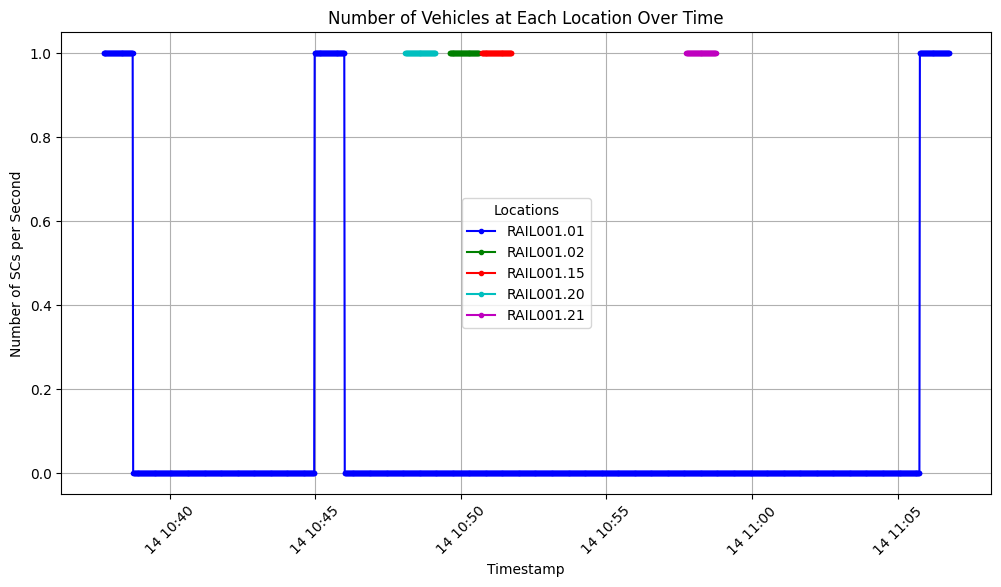

In [102]:
# ---------------------------------------------
# Analyze the duration of visits to specific locations
# ---------------------------------------------


# List of locations to analyze
locations = ["RAIL001.01", "RAIL001.02", "RAIL001.15", "RAIL001.20", 
    "RAIL001.21", "RAIL001.25", "RAIL001.40", "RAIL001.43", 
    "RAIL001.50", "RAIL001.54", "RAIL001.55", "RAIL001.62", 
    "RAIL001.65", "RAIL001.76", "RAIL001.81", "RAIL001.92", 
    "RAIL001.93", "RAIL001.101", "RAIL001.109"]
colors = ["b", "g", "r", "c", "m", "y"]  # Assign different colors for each location

plt.figure(figsize=(12, 6))  

for location, color in zip(locations, colors):
    # Filter the dataset for the current location
    df_location = df_duration[df_duration["Location"] == f"at {location}"]

    if df_location.empty:
        print(f"No data for {location}, skipping...")
        continue  # Skip plotting if no data is available for this location

    # Generate a time range covering the earliest to latest recorded timestamps
    time_range = pd.date_range(df_location["timestamp_start"].min(), df_location["timestamp_end"].max(), freq="S")

    # Initialize a dictionary to count the number of SCs at each second
    time_counts = {time: 0 for time in time_range}

    # Count the number of SCs present at each timestamp
    for _, row in df_location.iterrows():
        for t in pd.date_range(row["timestamp_start"], row["timestamp_end"], freq="S"):
            time_counts[t] += 1

    # Convert the time count dictionary into a DataFrame for plotting
    df_plot = pd.DataFrame(time_counts.items(), columns=["Timestamp", "SC Count"])
    df_plot.sort_values("Timestamp", inplace=True)  # Ensure timestamps are sorted chronologically

    # Plot the number of SCs present at the location over time
    plt.plot(df_plot["Timestamp"], df_plot["SC Count"], marker=".", linestyle="-", color=color, label=location)

# Customize the plot
plt.xlabel("Timestamp")
plt.ylabel("Number of SCs per Second")
plt.title("Number of Vehicles at Each Location Over Time")
plt.xticks(rotation=45)
plt.grid()
plt.legend(title="Locations")  
plt.show()
